<a href="https://colab.research.google.com/github/CaloCare/MachineLearning/blob/main/CaloCare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CaloCare**

## Importing Packages/Libraries

In [1]:
# Import necessary libraries
import os  # For file and directory operations
import shutil  # For moving and copying files
import random  # For generating random selections
import numpy as np  # For numerical operations

import matplotlib.pyplot as plt  # For plotting and visualizations
import matplotlib.image as mpimg  # For loading and displaying images
from PIL import Image  # For image processing

from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data augmentation
from tensorflow.keras.preprocessing import image  # For preprocessing images

# Import Keras components for model building
from keras.applications import MobileNetV2  # Pre-trained model for transfer learning
from tensorflow.keras.models import Sequential  # Sequential model structure
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Activation  # Layers for building neural networks
from tensorflow.keras.optimizers import Adam  # Optimizer for compiling the model
from tensorflow.keras.callbacks import ReduceLROnPlateau  # Learning rate scheduler
from tensorflow.keras.regularizers import l2  # Regularizer for reducing overfitting
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report  # For evaluation metrics
from tensorflow.keras.callbacks import EarlyStopping  # Early stopping for preventing overfitting

**Insight:**

This code imports a comprehensive set of libraries and tools essential for building and training a deep learning model for image classification. It includes utilities for file handling (`os`, `shutil`), data visualization (`matplotlib`, `PIL`), and numerical computations (`numpy`). The deep learning workflow leverages the MobileNetV2 model for transfer learning, combined with additional Keras layers to customize the architecture. It also integrates optimizers like Adam, regularization (e.g., `l2`), and callbacks such as `ReduceLROnPlateau` and `EarlyStopping` to optimize training and mitigate overfitting. Additionally, the inclusion of evaluation tools like confusion matrices and classification reports ensures robust performance analysis, making the code a solid foundation for developing image-based machine learning solutions.

## Data Wrangling

In [2]:
!pip install kaggle

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d 'faldoae/padangfood'

Dataset URL: https://www.kaggle.com/datasets/faldoae/padangfood
License(s): ODbL-1.0
100% 114M/114M [00:01<00:00, 93.9MB/s]
100% 114M/114M [00:01<00:00, 96.7MB/s]


In [7]:
import zipfile

with zipfile.ZipFile('padangfood.zip', 'r') as zip_ref:
    zip_ref.extractall('padangfood')

**Insight:**

The code automates the process of downloading and extracting a dataset from Kaggle. It begins by installing the Kaggle API client and setting up the necessary authentication using a `kaggle.json` file containing API credentials. After ensuring proper permissions, it downloads the "Padang Food" dataset from Kaggle using the dataset's unique identifier. Finally, the downloaded ZIP file is extracted into a folder named `padangfood`, making the dataset readily available for further processing or analysis. This workflow demonstrates an efficient way to integrate external datasets into a machine learning project.

### Assessing Data

Class: gulai_ikan - Sample Count: 111
-----------------------------------------------------


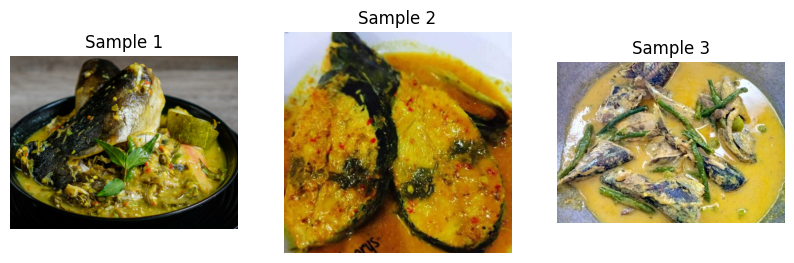



Class: ayam_pop - Sample Count: 113
-----------------------------------------------------


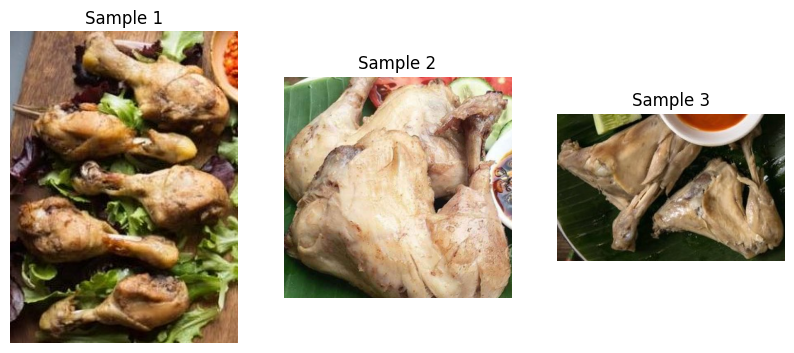



Class: telur_balado - Sample Count: 111
-----------------------------------------------------


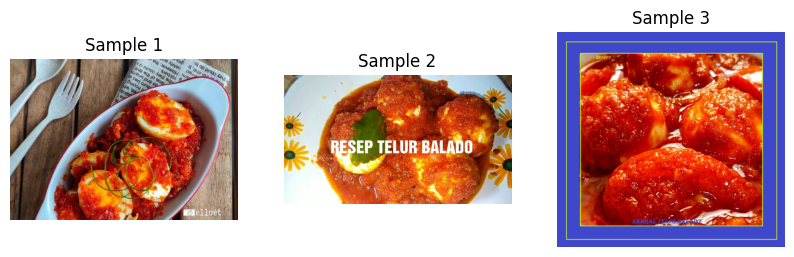



Class: telur_dadar - Sample Count: 116
-----------------------------------------------------


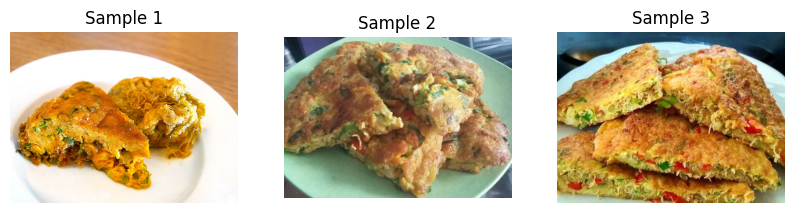



Class: dendeng_batokok - Sample Count: 109
-----------------------------------------------------


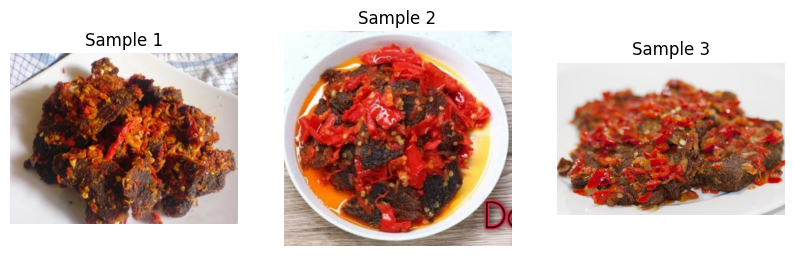



Class: daging_rendang - Sample Count: 104
-----------------------------------------------------


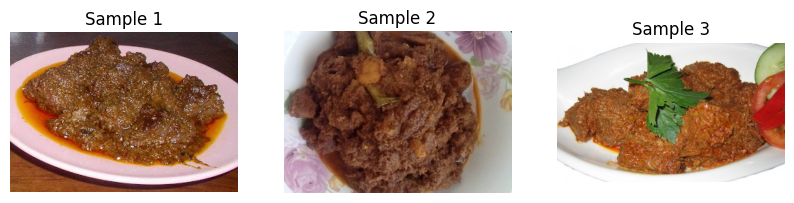



Class: gulai_tunjang - Sample Count: 119
-----------------------------------------------------


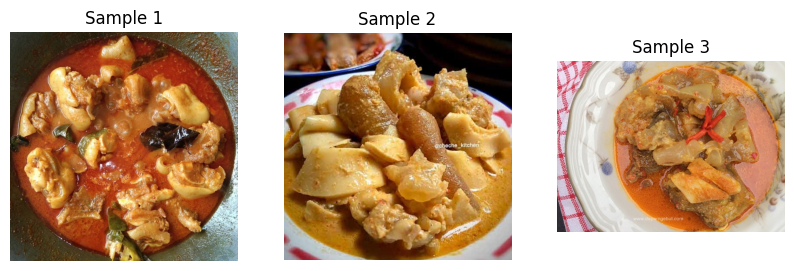



Class: ayam_goreng - Sample Count: 107
-----------------------------------------------------


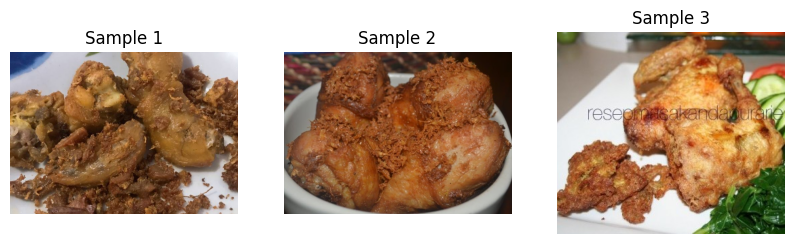



Class: gulai_tambusu - Sample Count: 103
-----------------------------------------------------


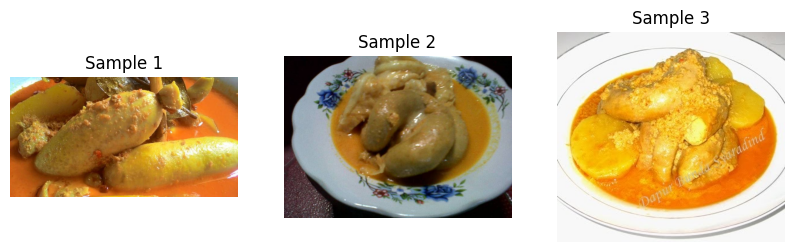

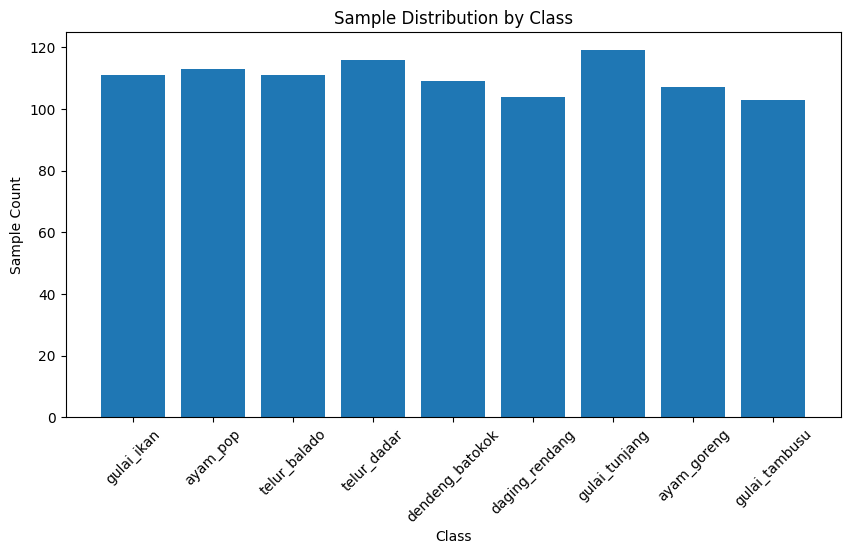

In [8]:
# Define the dataset folder location
dataset_folder = "/content/padangfood/dataset_padang_food"  # Path to the dataset folder

# Create a dictionary to store the number of samples in each class
class_counts = {}  # Dictionary to hold class names and their respective sample counts

# Loop through each class in the dataset
for class_name in os.listdir(dataset_folder):  # Iterate over all items in the dataset folder
    class_folder = os.path.join(dataset_folder, class_name)  # Get the full path of the class folder

    # Ensure that only folders (not files) are processed in the loop
    if os.path.isdir(class_folder):  # Check if the current item is a folder
        # Count the number of images in each class
        num_images = len([f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))])  # Only count files, not directories
        class_counts[class_name] = num_images  # Add the class and its image count to the dictionary

        # Display some sample images from each class
        print(f"Class: {class_name} - Sample Count: {num_images}")  # Print class name and sample count
        print("-----------------------------------------------------")
        plt.figure(figsize=(10, 5))  # Set the figure size for displaying sample images
        for i, image_file in enumerate([f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))][:3]):  # Select the first 3 image files
            # Full path to the image
            image_path = os.path.join(class_folder, image_file)  # Get the full path to the image
            # Read and display the image using Matplotlib
            plt.subplot(1, 3, i + 1)  # Create a subplot for each sample image
            image = mpimg.imread(image_path)  # Load the image
            plt.imshow(image)  # Display the image
            plt.title(f"Sample {i + 1}")  # Add a title to the image
            plt.axis('off')  # Remove axes for a cleaner display
        plt.show()  # Show the sample images
        print("\n")  # Add a newline for better readability

# Display the sample distribution for each class
plt.figure(figsize=(10, 5))  # Set the figure size for the bar plot
plt.bar(class_counts.keys(), class_counts.values())  # Create a bar plot of class counts
plt.title('Sample Distribution by Class')  # Add a title to the plot
plt.xlabel('Class')  # Label for the x-axis
plt.ylabel('Sample Count')  # Label for the y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()  # Display the bar plot

**Insight:**

This code provides a detailed overview of a dataset by counting and visualizing the number of images in each class. It iterates through the dataset directory, processes only folders representing classes, and calculates the total number of images in each class. Additionally, it visualizes up to three sample images from each class, offering a quick glimpse of the data content. Finally, it generates a bar plot to display the distribution of image counts across all classes, enabling a clear understanding of dataset balance and identifying potential class imbalances for further preprocessing or adjustments.

### Cleaning Data and Splitting

In [9]:
# Directory for the dataset
dataset_dir = "/content/padangfood/dataset_padang_food"  # Path to the main dataset directory

# List of each class name in the dataset
classes = ["ayam_goreng", "dendeng_batokok", "gulai_ikan", "telur_balado", "ayam_pop", "gulai_tambusu", "telur_dadar", "daging_rendang", "gulai_tunjang"]  # Names of the classes in the dataset

# Ratios for train, validation, and test sets
train_ratio = 0.8  # 80% of data for training
val_ratio = 0.1  # 10% of data for validation
test_ratio = 0.1  # 10% of data for testing

# Loop through each class in the dataset
for class_name in classes:  # Iterate over all class names
    # Path to the current class directory
    class_dir = os.path.join(dataset_dir, class_name)  # Full path to the directory of the current class

    # List all files in the current class directory
    files = os.listdir(class_dir)  # Get all files in the class directory

    # Shuffle files randomly to ensure random distribution
    random.shuffle(files)  # Randomize the order of files for unbiased splitting

    # Calculate the number of files for each train, validation, and test set
    num_files = len(files)  # Total number of files in the current class
    num_train = int(num_files * train_ratio)  # Number of files for the training set
    num_val = int(num_files * val_ratio)  # Number of files for the validation set
    num_test = num_files - num_train - num_val  # Remaining files for the test set

    # Split files into train, validation, and test sets
    train_files = files[:num_train]  # First portion of files for training
    val_files = files[num_train:num_train + num_val]  # Next portion of files for validation
    test_files = files[num_train + num_val:]  # Remaining files for testing

    # Create new directories for train, validation, and test sets
    for folder_name, file_list in [("train", train_files), ("val", val_files), ("test", test_files)]:  # Iterate over set types
        folder_path = os.path.join(dataset_dir, folder_name, class_name)  # Create a directory for the current set and class
        os.makedirs(folder_path, exist_ok=True)  # Create the directory if it doesn't already exist
        # Move files to the appropriate folder based on their set
        for file in file_list:  # Loop over each file in the current set
            src = os.path.join(class_dir, file)  # Source path of the file
            dst = os.path.join(folder_path, file)  # Destination path of the file
            shutil.move(src, dst)  # Move the file from source to destination

**Insight:**

This code organizes a dataset into training, validation, and test sets, ensuring proper data preparation for machine learning workflows. It iterates through each class directory, shuffles the images for randomness, and splits them based on predefined ratios `(80% for training, 10% each for validation and testing)`. The code creates separate directories for each set and moves the files accordingly, maintaining class structure. This process ensures a well-structured and balanced dataset, ready for model training and evaluation, while also reducing the risk of data leakage between the sets.

### Data Augmentation & Normalization

In [10]:
# Dataset directory
dataset_dir = "/content/padangfood/dataset_padang_food"  # Path to the main dataset directory

# Dimensions for each image
img_width, img_height = 256, 256  # Images will be resized to 256x256 pixels

# Batch size for images
batch_size = 64  # Number of images to process in a batch

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to a range of [0, 1].
    shear_range=0.2,  # Apply random shearing transformations up to 20%.
    zoom_range=0.2,  # Apply random zoom transformations up to 20%.
    horizontal_flip=True,  # Randomly flip images horizontally.
    rotation_range=40,  # Rotate images randomly up to 40 degrees.
    width_shift_range=0.2,  # Apply horizontal shifts up to 20% of the image width.
    height_shift_range=0.2,  # Apply vertical shifts up to 20% of the image height.
    brightness_range=[0.8, 1.2],  # Adjust brightness randomly between 80% and 120%.
    channel_shift_range=30,  # Shift color channels randomly up to 30 units.
    fill_mode='nearest'  # Use nearest pixel values to fill gaps created during transformations.
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values for validation set without augmentations
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values for test set without augmentations

# Data generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'train'),  # Path to the training set directory
    target_size=(img_width, img_height),  # Resize images to 256x256 pixels
    batch_size=batch_size,  # Process images in batches of 64
    class_mode='categorical')  # Use categorical labels (multi-class classification)

val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'val'),  # Path to the validation set directory
    target_size=(img_width, img_height),  # Resize images to 256x256 pixels
    batch_size=batch_size,  # Process images in batches of 64
    class_mode='categorical')  # Use categorical labels (multi-class classification)

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'test'),  # Path to the test set directory
    target_size=(img_width, img_height),  # Resize images to 256x256 pixels
    batch_size=batch_size,  # Process images in batches of 64
    class_mode='categorical',  # Use categorical labels (multi-class classification)
    shuffle=False)  # Do not shuffle test data to maintain consistency during evaluation

Found 790 images belonging to 9 classes.
Found 95 images belonging to 9 classes.
Found 108 images belonging to 9 classes.


**Insight:**

This code sets up data preprocessing and augmentation pipelines for a deep learning model, ensuring the dataset is ready for training, validation, and testing. It applies a series of augmentations, such as rotations, shearing, zooming, brightness adjustment, and flipping, to the training data, helping the model generalize better by exposing it to diverse variations. The validation and test datasets are normalized without augmentation to ensure consistent evaluation. Using the `flow_from_directory` function, the data is dynamically loaded from the directory, resized to 256x256 pixels, and batched for efficient processing. This approach ensures an optimized and well-prepared dataset for robust model development and evaluation.

### Training Data and Model Building


In [11]:
# Load the pre-trained MobileNetV2 model without the top layer
base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

# Unfreeze the top layers of MobileNetV2 for fine-tuning
for layer in base_model.layers[-20:]:  # Adjust to unfreeze top 20 layers
    layer.trainable = True

# Freeze the other layers to retain the general features from ImageNet
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Create a new model on top of the pre-trained base model
model = Sequential()
model.add(base_model)  # Add the base model as the first layer
model.add(Flatten())  # Flatten the output of the base model

# First Dense Layer with Regularization, Batch Normalization, Activation, and Dropout
model.add(Dense(512, kernel_regularizer=l2(0.001)))  # Increase to 512 units
model.add(BatchNormalization())  # Normalize activations
model.add(Activation('relu'))  # ReLU activation function
model.add(Dropout(0.5))  # Dropout with 50% to reduce overfitting

# Second Dense Layer with Regularization, Batch Normalization, Activation, and Dropout
model.add(Dense(256, kernel_regularizer=l2(0.001)))  # Add another dense layer with 256 units
model.add(BatchNormalization())  # Batch normalization
model.add(Activation('relu'))  # ReLU activation
model.add(Dropout(0.3))  # Dropout with 30% to reduce overfitting further

# Output Layer
model.add(Dense(9, activation='softmax'))  # Output layer with softmax for multi-class classification

# Compile the model
# Adam optimizer is used for adaptive learning rate adjustments
# Categorical crossentropy is the loss function since this is a multi-class classification problem
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define a learning rate scheduler to reduce the learning rate when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Define early stopping to stop training if validation loss does not improve for 5 consecutive epochs
# The best weights from the epoch with the lowest validation loss are restored
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using the training and validation data generators
history = model.fit(
    train_generator,  # Training data generator
    validation_data=val_generator,  # Validation data generator
    epochs=100,  # Set the maximum number of training epochs
    callbacks=[lr_scheduler, early_stopping]  # Use learning rate scheduler and early stopping
)

<ipython-input-11-389b82906c6d>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.1214 - loss: 3.9932 - val_accuracy: 0.1684 - val_loss: 3.5848 - learning_rate: 1.0000e-05
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 649ms/step - accuracy: 0.1854 - loss: 3.7904 - val_accuracy: 0.2947 - val_loss: 3.2356 - learning_rate: 1.0000e-05
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 720ms/step - accuracy: 0.2203 - loss: 3.5989 - val_accuracy: 0.4842 - val_loss: 2.9756 - learning_rate: 1.0000e-05
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 646ms/step - accuracy: 0.2900 - loss: 3.2918 - val_accuracy: 0.5158 - val_loss: 2.7852 - learning_rate: 1.0000e-05
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 723ms/step - accuracy: 0.4005 - loss: 3.0901 - val_accuracy: 0.6211 - val_loss: 2.6502 - learning_rate: 1.0000e-05
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 573ms/step - accuracy: 0.4349 - loss: 3.0421 - val_accuracy: 0.7053 - val_loss: 2.5561 - learning_rate: 1.0000e-05
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 720ms/step - accuracy: 0

**Insight:**

The code demonstrates an efficient workflow for transfer learning using the MobileNetV2 model pre-trained on ImageNet. By freezing earlier layers and fine-tuning the last 20 layers, the model leverages pre-learned features while adapting to the specific dataset. The addition of dense layers with L2 regularization, batch normalization, and dropout helps improve generalization and prevent overfitting. The use of adaptive learning rate adjustments and early stopping ensures efficient training by dynamically optimizing performance and preventing unnecessary epochs. This setup is ideal for tackling multi-class classification tasks with a balanced trade-off between speed and accuracy.

## Model Evaluation and Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - accuracy: 0.9219 - loss: 1.6240
Test accuracy: 0.921875


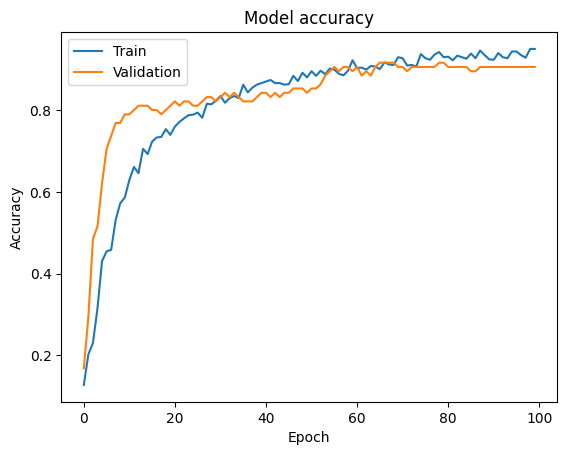

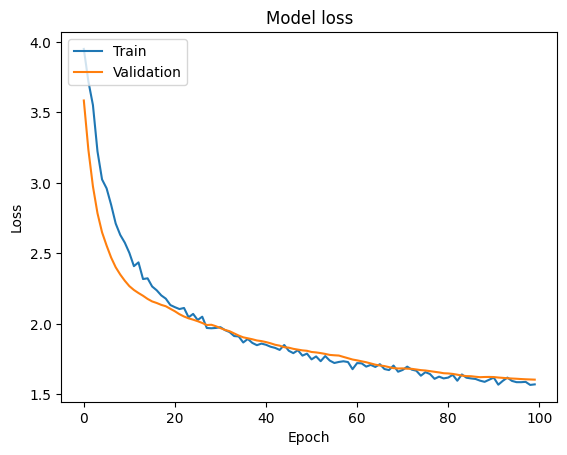

In [12]:
# Evaluate the model's performance on the test dataset
# The evaluation returns the test loss and accuracy metrics
# The number of steps is calculated as the total test samples divided by the batch size
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)  # Print the test accuracy for reference

# Plot the training and validation accuracy over epochs
# This visualizes how the model's accuracy improved during training
plt.plot(history.history['accuracy'])  # Plot training accuracy
plt.plot(history.history['val_accuracy'])  # Plot validation accuracy
plt.title('Model accuracy')  # Add a title to the plot
plt.xlabel('Epoch')  # Label the x-axis as 'Epoch'
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.legend(['Train', 'Validation'], loc='upper left')  # Add a legend for training and validation accuracy
plt.show()  # Display the plot

# Plot the training and validation loss over epochs
# This shows how the loss decreased during training and validation
plt.plot(history.history['loss'])  # Plot training loss
plt.plot(history.history['val_loss'])  # Plot validation loss
plt.title('Model loss')  # Add a title to the plot
plt.xlabel('Epoch')  # Label the x-axis as 'Epoch'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.legend(['Train', 'Validation'], loc='upper left')  # Add a legend for training and validation loss
plt.show()  # Display the plot

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 7s/step


<Figure size 1600x1600 with 0 Axes>

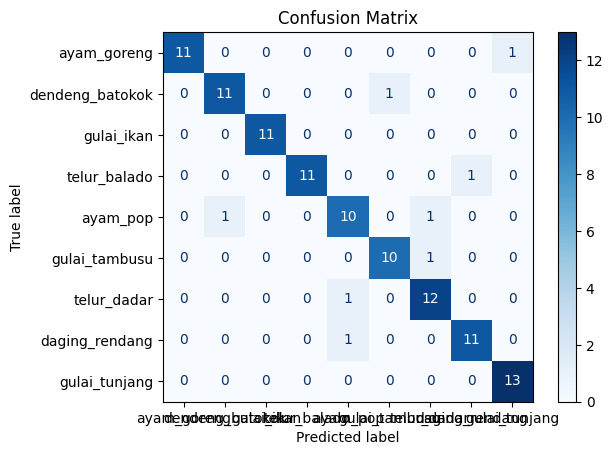

                 precision    recall  f1-score   support

    ayam_goreng       1.00      0.92      0.96        12
dendeng_batokok       0.92      0.92      0.92        12
     gulai_ikan       1.00      1.00      1.00        11
   telur_balado       1.00      0.92      0.96        12
       ayam_pop       0.83      0.83      0.83        12
  gulai_tambusu       0.91      0.91      0.91        11
    telur_dadar       0.86      0.92      0.89        13
 daging_rendang       0.92      0.92      0.92        12
  gulai_tunjang       0.93      1.00      0.96        13

       accuracy                           0.93       108
      macro avg       0.93      0.93      0.93       108
   weighted avg       0.93      0.93      0.93       108



In [13]:
# Get the predicted classes from the model on the test dataset
# The predictions are made for each sample, and the class with the highest probability is selected
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Retrieve the true labels for the test dataset
# These are the actual class indices for the test samples
y_true = test_generator.classes

# Calculate the confusion matrix to evaluate the classification performance
# The confusion matrix shows the number of correct and incorrect predictions for each class
cm = confusion_matrix(y_true, y_pred)

# Define the list of class names for better interpretation of the confusion matrix
classes = ["ayam_goreng", "dendeng_batokok", "gulai_ikan", "telur_balado",
           "ayam_pop", "gulai_tambusu", "telur_dadar", "daging_rendang", "gulai_tunjang"]

# Display the confusion matrix as a heatmap
plt.figure(figsize=(16, 16))  # Set the figure size for better readability
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)  # Create the display object
disp.plot(cmap=plt.cm.Blues)  # Plot the confusion matrix with a blue colormap
plt.title('Confusion Matrix')  # Add a title to the plot
plt.show()  # Display the confusion matrix

# Calculate and print the classification report
# The report includes metrics like precision, recall, and F1-score for each class
report = classification_report(y_true, y_pred, target_names=classes)
print(report)  # Display the classification report in text format

Saving telur_dadar (22).jpg to telur_dadar (22).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


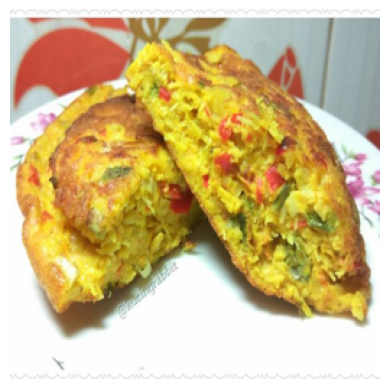

Predicted Class: telur_dadar


In [14]:
from tensorflow.keras.preprocessing import image  # For image preprocessing
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For displaying images and plots
from google.colab import files  # For file upload in Google Colab
from PIL import Image  # For handling image files

# Get the mapping of index to class name
# The `class_indices` dictionary maps class names to indices; reverse it to get indices to class names
class_indices = train_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}  # Reverse the dictionary to get index-to-class mapping

# Function to upload and load images
uploaded = files.upload()  # Allows users to upload image files in Google Colab

# Iterate through the uploaded files
for file_name in uploaded.keys():
    # Load the uploaded image file using PIL
    img = Image.open(file_name)
    img = img.resize((img_width, img_height))  # Resize the image to match the model's expected input size
    img_array = image.img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension for prediction
    img_array /= 255.0  # Normalize pixel values to the range [0, 1]

    # Make a prediction using the trained model
    prediction = model.predict(img_array)  # Get the prediction probabilities for each class
    predicted_class = np.argmax(prediction, axis=1)  # Determine the class with the highest probability

    # Display the uploaded image
    plt.imshow(img)  # Show the image using Matplotlib
    plt.axis('off')  # Remove axes for better visualization
    plt.show()

    # Print the predicted class name based on the model's output
    print("Predicted Class:", class_names[predicted_class[0]])

## Conclusion

The model has shown a strong ability to accurately classify various Indonesian dishes, achieving a `high accuracy of 92%`. Performance metrics such as `precision, recall, and F1-score` remain consistently high across most categories, indicating balanced learning and effective generalization on both training and validation data. The `confusion matrix and classification` report reveal that certain dishes, like daging_rendang, are mostly well-recognized by the model, though occasional misclassifications with similar dishes suggest there may be visual overlaps that challenge the model’s classification abilities.

To further improve accuracy, especially for similar-looking dishes, additional training images and data augmentation techniques could be employed. Techniques such as zooming, rotation, or color adjustments might help the model learn subtle differences and improve classification robustness. This approach would support the model in distinguishing visually similar dishes more effectively, thereby minimizing potential misclassifications and enhancing overall performance in real-world applications.